In [9]:
from pathlib import Path
import xarray as xr
import warnings

from pyorg.core.geometry import get_cells_area

import pycompo.coord as pccoord
import pycompo.ellipse as pcellipse
import pycompo.feature_cutout as pcfeatcut
import pycompo.filter as pcfilter
import pycompo.plot as pcplot
import pycompo.sst_features as pcsst
import pycompo.utils as pcutils
import pycompo.wind as pcwind

from pycompo.composite import interpolate2compo_coords

warnings.filterwarnings(action='ignore')

# read in configuration file
config_file = "/home/m/m300738/libs/pycompo/config/settings_template.yaml"
config = pcutils.read_yaml_config(config_file)

### Read in data

In [3]:
varlst = [config['data']['feature_var']] + config['data']['wind_vars'] + \
    config['data']['study_vars']

# Read in data for analysis
infiles = []
for var in varlst:
    inpath = Path(config['data']['inpaths'][var])
    in_pattern = \
        f"{config['exp']}_tropical_{var}_20200801T000000Z-20200901T000000Z.nc"
    infiles.extend(sorted([str(f) for f in inpath.rglob(in_pattern)]))
dset = xr.open_mfdataset(infiles, parallel=True).squeeze()
dset = dset.isel(time=slice(0, 2))
for var in config['data']['wind_vars'] + config['data']['study_vars']:
    dset[var] = dset[var].compute()
dset['sfcwind'] = pcwind._calc_sfcwind_speed(dset['uas'], dset['vas'])
dset['cell_area'] = get_cells_area(dset)

### Building SST anomalies
##### Infos on the filtering in degree space
Here we use a characteristic wavelength in degree since this has three advantages:
1) We remove the necessity to transform to km and can easily use a Gaussian filter
2) Ocean eddies - and thus temperature anomalies - tend to become smaller towards higher latitudes due to the Coriolis effect. Thus, cutting at a certain wavenumber instead of a certain wavelength is also physically reasonable.
3) We are in the deep tropics where the difference between longitudes and distances is small anyways.

Nevertheless, the charcateristic wavenumber has to be submitted as a characteristic wavelength at the equator -- it will be transformed internally.

In [10]:
if config['detrend']['switch']:
    feature_var = config['data']['feature_var']

    # Read in data for building the climatology
    inpath = Path(config['data']['inpaths'][feature_var])
    in_pattern = f"{config['exp']}_tropical_{feature_var}_*.nc"
    infiles = sorted([str(f) for f in inpath.rglob(in_pattern)])
    dset_clim = xr.open_mfdataset(infiles, parallel=True).squeeze()
    
    # Detrend dataset with multiyear monthly climatology
    climatology = pcfilter.build_hourly_climatology(
        dset_clim, clim_baseyear=str(config['detrend']['clim_baseyear'])
        )
    rolling_climatology = pcutils.circ_roll_avg(
        climatology, config['detrend']['clim_avg_days'], config['data']['spd'],
        )
    dset[f'{feature_var}_detrend'] = \
        dset[feature_var] - rolling_climatology[feature_var]
    dset[f'{feature_var}_detrend'] = dset[f'{feature_var}_detrend'].compute()
    config['data']['feature_var'] = f'{feature_var}_detrend'

# Gaussian filter to extract anomalies
dset = xr.merge([
    dset,
    pcfilter.get_gaussian_filter_bg_ano(
        dset[config['data']['feature_var']], **config['filter'],
        )
    ])
dset = dset.sel(lat=slice(*config['lat_range']), drop=True)
orig_coords = pccoord.get_coords_orig(dset)

### Visualization

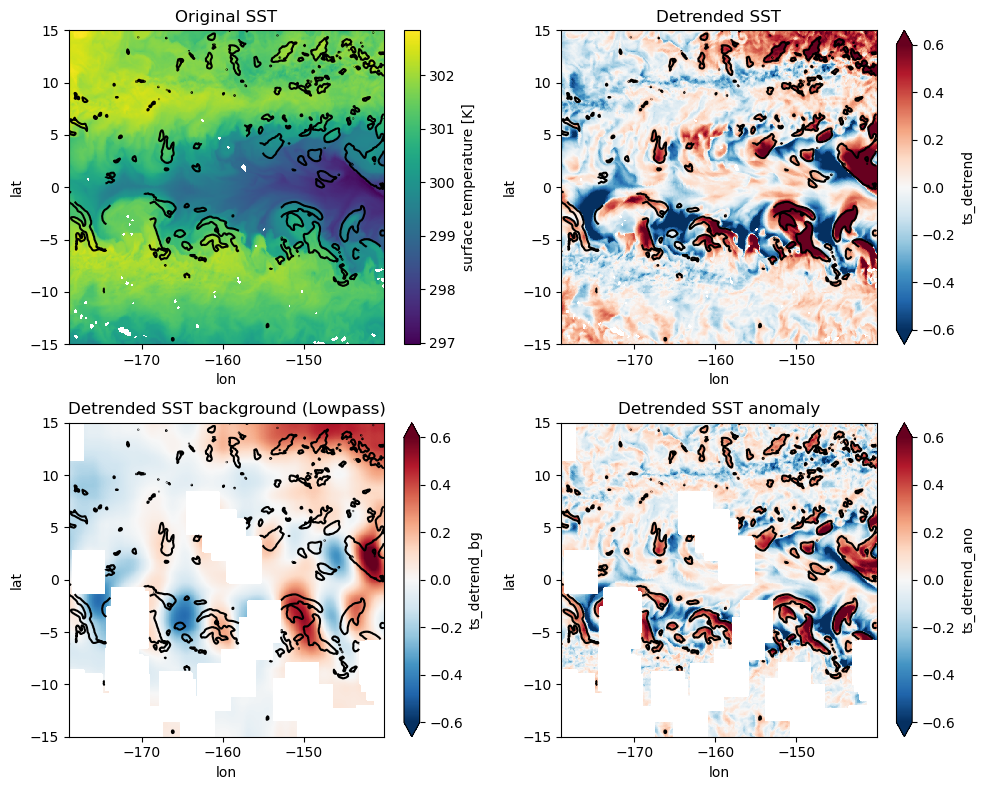

In [ ]:
if config['detrend']['switch']:
    # User settings of spatiotemporal plotting area
    lat_slice = slice(0, 10)
    lat_slice = slice(-15, 15)
    lon_slice = slice(-170, -160)
    lon_slice = slice(-179, -140)
    time_index = 0

    pcplot.plot_preprocessing_overview_map(
        dset.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice),
        config['data']['feature_var'], config['feature']['threshold'], 
        )

### Detection of SST clusters and cutout of corresponding data

In [26]:
dset[f"{config['data']['feature_var']}_feature"], feature_props = \
    pcsst.extract_sst_features(
        dset[f"{config['data']['feature_var']}_ano"], **config['feature']
    )
dset, feature_props, feature_data = pcfeatcut.get_featcen_data_cutouts(
    dset, feature_props, config['cutout']['search_RadRatio'],
    )

feature_ellipse = pcellipse.get_ellipse_params(feature_props, orig_coords)

feature_props = pcwind.calc_feature_bg_wind(
    feature_props, feature_data, config['data']['wind_vars'],
    )
feature_data = pccoord.add_featcen_coords(
    orig_coords, feature_data, feature_props, feature_ellipse,
    )

### Visualization of the SST clusters

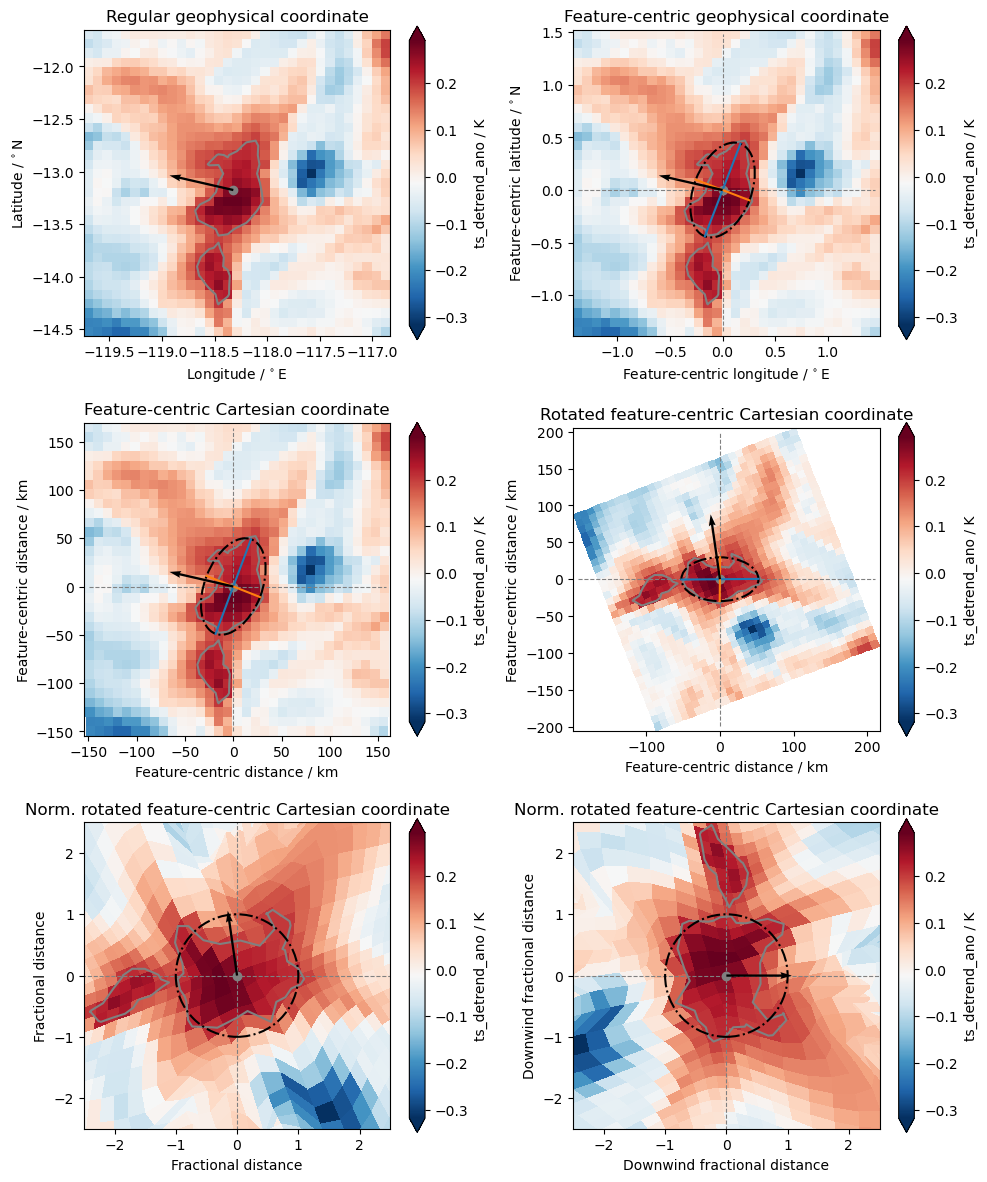

In [27]:
feature_id = 1
wind = feature_props[['bg_uas', 'bg_vas']]
pcplot.plot_coord_trafo(
    feature_data, feature_ellipse, wind, feature_id,
    f"{config['data']['feature_var']}_ano", config['feature']['threshold'],
    )

### Create composite

In [28]:
compo_varlst = [
    f"{config['data']['feature_var']}_ano", "pr_ano", "prw_ano", "hfls_ano",
    "hfss_ano", "sfcwind_ano",
    ]
feature_compo_data = {
    var: interpolate2compo_coords(
        feature_data,
        (config['composite']['compo_x'], config['composite']['compo_y']),
        var
        ) for var in compo_varlst
    }
feature_compo_data = xr.merge([feature_compo_data[var] for var in compo_varlst])

KeyError: 'pr_ano'

### Linear

Text(0, 0.5, 'Crosswind fractional distance')

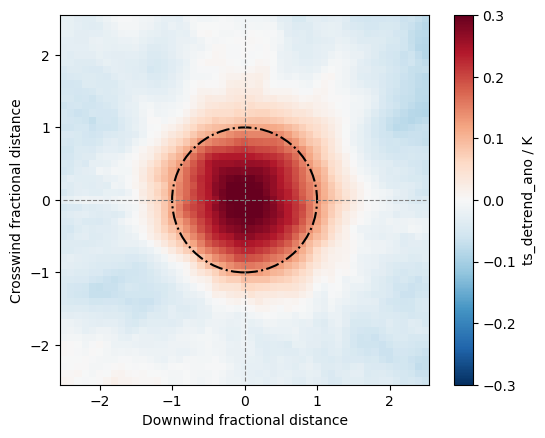

In [21]:
import matplotlib.pyplot as plt
plt.pcolormesh(
    feature_compo_data['En_rota2_featcen_x'],
    feature_compo_data['En_rota2_featcen_y'],
    feature_compo_data.mean(dim='feature').transpose(),
    cmap="RdBu_r", vmin=-0.3, vmax=0.3,
)
ymin = feature_compo_data['En_rota2_featcen_y'].min()
ymax = feature_compo_data['En_rota2_featcen_y'].max()
xmin = feature_compo_data['En_rota2_featcen_x'].min()
xmax = feature_compo_data['En_rota2_featcen_x'].max()
plt.gca().vlines(x=0, ymin=ymin, ymax=ymax, lw=0.8, ls='--', color='gray')
plt.gca().hlines(y=0, xmin=xmin, xmax=xmax, lw=0.8, ls='--', color='gray')

circle = plt.Circle([0, 0], 1, fill=False, color='k', ls='-.', lw=1.5)
plt.gca().add_patch(circle)
plt.gca().set_aspect('equal')
plt.colorbar(label="ts_detrend_ano / K")

plt.xlabel('Downwind fractional distance')
plt.ylabel('Crosswind fractional distance')

Text(0, 0.5, 'Crosswind fractional distance')

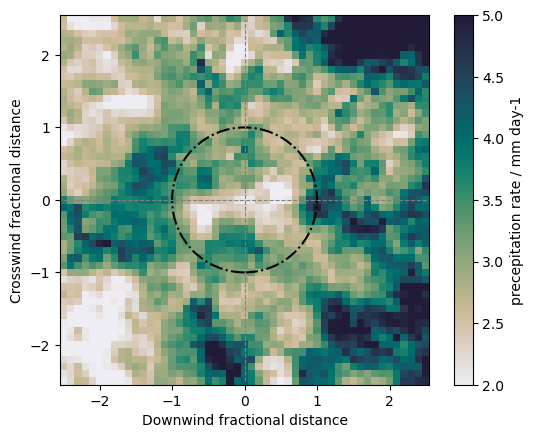

In [20]:
import matplotlib.pyplot as plt
import cmocean

plt.pcolormesh(
    feature_compo_data_pr['En_rota2_featcen_x'],
    feature_compo_data_pr['En_rota2_featcen_y'],
    feature_compo_data_pr.mean(dim='feature').transpose(),
    cmap=cmocean.cm.rain, vmin=2, vmax=5,
)
ymin = feature_compo_data_pr['En_rota2_featcen_y'].min()
ymax = feature_compo_data_pr['En_rota2_featcen_y'].max()
xmin = feature_compo_data_pr['En_rota2_featcen_x'].min()
xmax = feature_compo_data_pr['En_rota2_featcen_x'].max()
plt.gca().vlines(x=0, ymin=ymin, ymax=ymax, lw=0.8, ls='--', color='gray')
plt.gca().hlines(y=0, xmin=xmin, xmax=xmax, lw=0.8, ls='--', color='gray')

circle = plt.Circle([0, 0], 1, fill=False, color='k', ls='-.', lw=1.5)
plt.gca().add_patch(circle)
plt.gca().set_aspect('equal')
plt.colorbar(label="precepitation rate / mm day-1")

plt.xlabel('Downwind fractional distance')
plt.ylabel('Crosswind fractional distance')

Text(0, 0.5, 'Crosswind fractional distance')

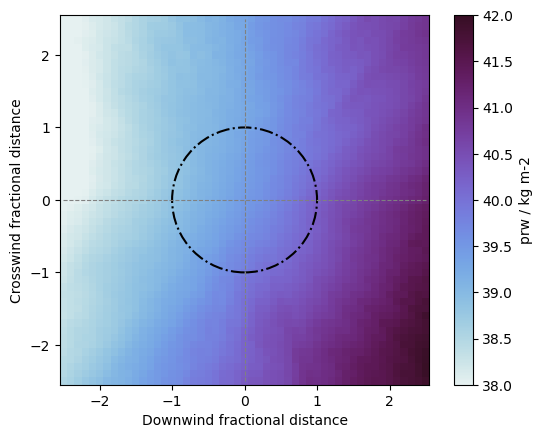

In [23]:
plt.pcolormesh(
    feature_compo_data_prw['En_rota2_featcen_x'],
    feature_compo_data_prw['En_rota2_featcen_y'],
    feature_compo_data_prw.mean(dim='feature').transpose(),
    cmap=cmocean.cm.dense, vmin=38, vmax=42,
)
ymin = feature_compo_data_prw['En_rota2_featcen_y'].min()
ymax = feature_compo_data_prw['En_rota2_featcen_y'].max()
xmin = feature_compo_data_prw['En_rota2_featcen_x'].min()
xmax = feature_compo_data_prw['En_rota2_featcen_x'].max()
plt.gca().vlines(x=0, ymin=ymin, ymax=ymax, lw=0.8, ls='--', color='gray')
plt.gca().hlines(y=0, xmin=xmin, xmax=xmax, lw=0.8, ls='--', color='gray')

circle = plt.Circle([0, 0], 1, fill=False, color='k', ls='-.', lw=1.5)
plt.gca().add_patch(circle)
plt.gca().set_aspect('equal')
plt.colorbar(label="prw / kg m-2")

plt.xlabel('Downwind fractional distance')
plt.ylabel('Crosswind fractional distance')

Text(0, 0.5, 'Crosswind fractional distance')

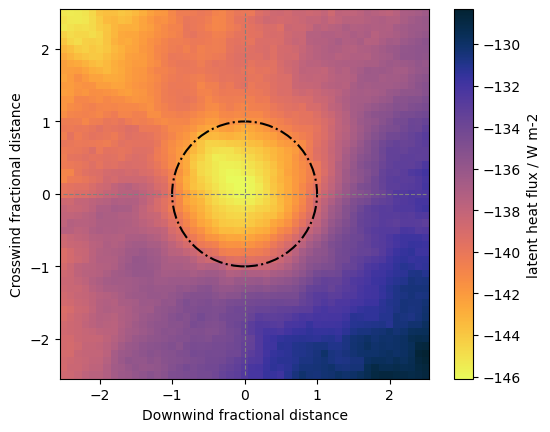

In [46]:
plt.pcolormesh(
    feature_compo_data_hfls['En_rota2_featcen_x'],
    feature_compo_data_hfls['En_rota2_featcen_y'],
    feature_compo_data_hfls.mean(dim='feature').transpose(),
    cmap=cmocean.cm.thermal_r, #vmin=38, vmax=42,
)
ymin = feature_compo_data_hfls['En_rota2_featcen_y'].min()
ymax = feature_compo_data_hfls['En_rota2_featcen_y'].max()
xmin = feature_compo_data_hfls['En_rota2_featcen_x'].min()
xmax = feature_compo_data_hfls['En_rota2_featcen_x'].max()
plt.gca().vlines(x=0, ymin=ymin, ymax=ymax, lw=0.8, ls='--', color='gray')
plt.gca().hlines(y=0, xmin=xmin, xmax=xmax, lw=0.8, ls='--', color='gray')

circle = plt.Circle([0, 0], 1, fill=False, color='k', ls='-.', lw=1.5)
plt.gca().add_patch(circle)
plt.gca().set_aspect('equal')
plt.colorbar(label="latent heat flux / W m-2")

plt.xlabel('Downwind fractional distance')
plt.ylabel('Crosswind fractional distance')

Text(0, 0.5, 'Crosswind fractional distance')

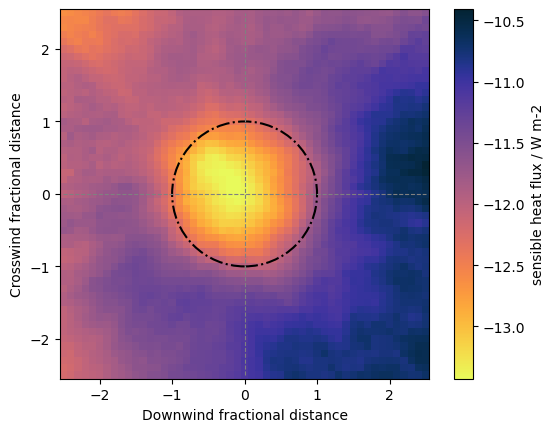

In [47]:
plt.pcolormesh(
    feature_compo_data_hfss['En_rota2_featcen_x'],
    feature_compo_data_hfss['En_rota2_featcen_y'],
    feature_compo_data_hfss.mean(dim='feature').transpose(),
    cmap=cmocean.cm.thermal_r,# vmin=38, vmax=42,
)
ymin = feature_compo_data_hfss['En_rota2_featcen_y'].min()
ymax = feature_compo_data_hfss['En_rota2_featcen_y'].max()
xmin = feature_compo_data_hfss['En_rota2_featcen_x'].min()
xmax = feature_compo_data_hfss['En_rota2_featcen_x'].max()
plt.gca().vlines(x=0, ymin=ymin, ymax=ymax, lw=0.8, ls='--', color='gray')
plt.gca().hlines(y=0, xmin=xmin, xmax=xmax, lw=0.8, ls='--', color='gray')

circle = plt.Circle([0, 0], 1, fill=False, color='k', ls='-.', lw=1.5)
plt.gca().add_patch(circle)
plt.gca().set_aspect('equal')
plt.colorbar(label="sensible heat flux / W m-2")

plt.xlabel('Downwind fractional distance')
plt.ylabel('Crosswind fractional distance')

Text(0, 0.5, 'Crosswind fractional distance')

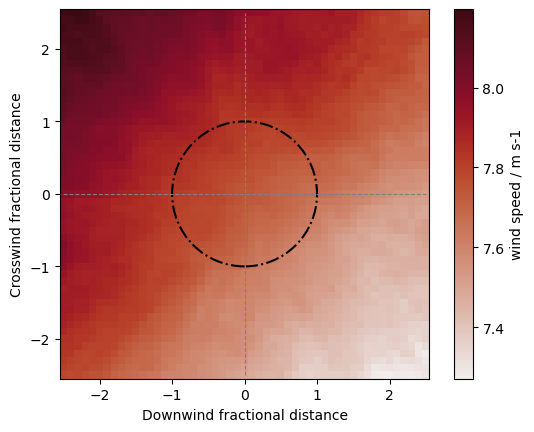

In [58]:
plt.pcolormesh(
    feature_compo_data_sfcwind['En_rota2_featcen_x'],
    feature_compo_data_sfcwind['En_rota2_featcen_y'],
    feature_compo_data_sfcwind.mean(dim='feature').transpose(),
    cmap=cmocean.cm.amp,# vmin=38, vmax=42,
)
ymin = feature_compo_data_sfcwind['En_rota2_featcen_y'].min()
ymax = feature_compo_data_sfcwind['En_rota2_featcen_y'].max()
xmin = feature_compo_data_sfcwind['En_rota2_featcen_x'].min()
xmax = feature_compo_data_sfcwind['En_rota2_featcen_x'].max()
plt.gca().vlines(x=0, ymin=ymin, ymax=ymax, lw=0.8, ls='--', color='gray')
plt.gca().hlines(y=0, xmin=xmin, xmax=xmax, lw=0.8, ls='--', color='gray')

circle = plt.Circle([0, 0], 1, fill=False, color='k', ls='-.', lw=1.5)
plt.gca().add_patch(circle)
plt.gca().set_aspect('equal')
plt.colorbar(label="wind speed / m s-1")

plt.xlabel('Downwind fractional distance')
plt.ylabel('Crosswind fractional distance')

# SANDBOX

In [ ]:
# Split warm and cold SST patches
def sel_feature_ano_mode(feature_props, anomaly_modes):
    feature_modes = {}
    for ano in anomaly_modes:
        if ano == 'warm':
            feature_modes['warm'] = feature_props.where(
                feature_props['ts_detrend_ano_mean'] > 0, drop=True,
                )
        elif ano == 'cold':
            feature_modes['cold'] = feature_props.where(
                feature_props['ts_detrend_ano_mean'] < 0, drop=True,
                )
        else:
            raise ValueError(
                "Composites can be based either on warm or on cold anomalies." +
                "Please provide a valid anomaly mode: 'cold' or 'warm' or both!"
                )
        


def _select_feature(cond, feature_props, a)
    

# Remap to uniform coordinate sytem


# Calculate the mean

### Create background wind normalized natural coordinate

In [ ]:
def get_wind_coords(
        winds: xr.Dataset,
        feature_ellipse: dict,
        ) -> dict:
    winds_rota_featcen_cart = get_rota_featcen_cart_winds(
        winds, feature_ellipse['featcen_cart']['polar_angle_rad'],
        )
    winds_rota2_featcen_cart = get_rota2_featcen_cart_winds(
        winds_rota_featcen_cart
    )
    return {
        'orig': winds,
        'rota_featcen_cart': winds_rota_featcen_cart,
        'norm_rota2_featcen_cart': winds_rota2_featcen_cart,
        }


def get_rota_featcen_cart_winds(
        wind: xr.Dataset,
        rot_angle_rad: xr.DataArray,
        ) -> xr.Dataset:
    wind['bg_uas'], wind['bg_vas'] = pccoord._calc_rota_featcen_cart_coords(
        wind['bg_uas'], wind['bg_vas'], rot_angle_rad,
    )
    return wind


def get_rota2_featcen_cart_winds(wind: xr.Dataset) -> xr.Dataset:
    rot_angle_rad = np.arctan2(wind['bg_vas'], wind['bg_uas'])
    wind['bg_uas'], wind['bg_vas'] = pccoord._calc_rota_featcen_cart_coords(
        wind['bg_uas'], wind['bg_vas'], rot_angle_rad,
    )
    return wind


winds = get_wind_coords(feature_props[['bg_uas', 'bg_vas']], feature_ellipse)

In [45]:
get_wind_coords(feature_props[['bg_uas', 'bg_vas']], feature_ellipse)['orig']

<xarray.Dataset>
Dimensions:     (feature: 539)
Coordinates:
    feature_id  (feature) int64 27 54 59 64 71 84 ... 1908 1913 1929 1943 1947
Dimensions without coordinates: feature
Data variables:
    bg_uas      (feature) float64 -3.017 -10.42 -4.988 ... -6.957 3.194 6.101
    bg_vas      (feature) float64 7.485 2.382 10.72 ... 0.007019 6.859 -3.922